In [1]:
import nbdHelp as ndb
import ndbDELETE as ndb2
from functools import partial

import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import scipy.ndimage
from scipy.spatial import Voronoi, voronoi_plot_2d

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import math
from collections import defaultdict
import numpy as np

import io
import base64
from IPython.display import HTML, display
import matplotlib.pyplot as plt

rc('animation', html='jshtml')


In [2]:
in_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/df_in.parquet'
out_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/df_out.parquet'
sup_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/sup_file.parquet'

df_in = pd.read_parquet(in_path)
df_out = pd.read_parquet(out_path)
sup_file = pd.read_parquet(sup_path)
map_file= pd.read_parquet('/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/mapping_df.parquet')

print('Loaded df_in:', df_in.shape)
print('Loaded df_out:', df_out.shape)
print('Loaded sup_file:', sup_file.shape)
print('Loaded map_file:', map_file.shape)

Loaded df_in: (4880579, 24)
Loaded df_out: (562936, 7)
Loaded sup_file: (18009, 42)
Loaded map_file: (14108, 5)


In [3]:
# Merge df_out with df_in to get player_role for each row
df_out_merged = df_out.merge(df_in[['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_role']],
                      on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
                      how='left')

In [4]:
print(df_in.columns)

Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y',
       'flat_play_id'],
      dtype='object')


In [5]:
# get array of all flat_play_ids (from mapping dataframe)
flat_play_ids = np.sort(map_file['flat_play_id'].unique())
print(len(flat_play_ids))
print(flat_play_ids[:-10])

14108
[    0     1     2 ... 14095 14096 14097]


In [6]:
def prep_for_heat(id, df=None, n=2, angle_unit='rad'):
    """
    Prepare receiver + defender final positions and velocities for a heatmap.

    Inputs:
      - id: play id 
      - df: optional DataFrame; if provided, the function calls
            ndb.get_last_n_frames_coords(id_or_coords, df, n=n)
      - n: number of frames to request when calling get_last_n_frames_coords (default 2)
      - angle_unit: 'deg' (default) or 'rad' for velocity direction units.

    Returns:
      (receiver_final_x, receiver_final_y, receiver_final_v_mag, receiver_final_v_dir),
      defender_positions,   # tuple of (x,y) tuples: ((d1x,d1y),(d2x,d2y),...)
      defender_v_mags,      # tuple of mags: (d1_mag, d2_mag, ...)
      defender_v_dirs       # tuple of directions: (d1_dir, d2_dir, ...)

    Notes / assumptions:
      - get_last_n_frames_coords returns a flat list: (nfl_id, frame_id, x, y, player_role)
      - Velocities are computed from the last two frames for each player (if available).
      - If only one frame exists for a player, v_mag = 0 and v_dir = np.nan.
      - Receiver is detected by player_role starting with 'r' (case-insensitive) or containing 'receiver'.
      - Players whose role contains 'ball' or 'football' are ignored.
    """
    

    
    coords = ndb.get_last_n_frames_coords(id, df, n=n)
    
    # Expect coords: list of (nfl_id, frame_id, x, y, player_role)
    # Group by nfl_id, keep tuples of (frame_id, x, y, role)
    players = defaultdict(list)
    for item in coords:
        try:
            nfl_id, frame_id, x, y, role = item
        except Exception:
            # skip malformed entries
            continue
        players[nfl_id].append((frame_id, float(x), float(y), str(role)))

    # Sort each player's frames by frame_id ascending
    for pid in list(players.keys()):
        players[pid].sort(key=lambda t: t[0])

    # Helper to compute velocity from last two frames (or return 0, nan)
    def compute_vel(frames):
        # frames: list of (frame_id, x, y, role) sorted by frame_id asc
        if len(frames) >= 2:
            _, x1, y1, _ = frames[-2]
            _, x2, y2, _ = frames[-1]
            dx = x2 - x1
            dy = y2 - y1
            mag = np.clip(float(math.hypot(dx, dy))*10,0,10.5)
            ang = float(math.atan2(dy, dx))
            if angle_unit == 'deg':
                ang = math.degrees(ang)
            return mag, ang
        else:
            return 0.0, float('nan')

    # Identify receiver: prefer a player whose most-recent role startswith 'r' or contains 'receiver'.
    receiver_pid = None
    receiver_candidate_frame = -1
    for pid, frames in players.items():
        last_role = frames[-1][3].lower() if frames and frames[-1][3] is not None else ''
        if last_role.startswith('r') or 'receiver' in last_role or 'target' in last_role:
            # choose the candidate with the most recent frame (highest frame id)
            last_frame_id = frames[-1][0]
            if last_frame_id >= receiver_candidate_frame:
                receiver_candidate_frame = last_frame_id
                receiver_pid = pid

    # If none found, try to find a player named 'receiver' anywhere in role strings
    if receiver_pid is None:
        for pid, frames in players.items():
            last_role = frames[-1][3].lower() if frames and frames[-1][3] is not None else ''
            if 'receiver' in last_role:
                receiver_pid = pid
                break

    # Prepare receiver outputs
    if receiver_pid is not None:
        rframes = players[receiver_pid]
        recv_x = float(rframes[-1][1])
        recv_y = float(rframes[-1][2])
        recv_v_mag, recv_v_dir = compute_vel(rframes)
    else:
        # fallback: return NaNs if no receiver detected
        recv_x = float('nan')
        recv_y = float('nan')
        recv_v_mag = 0.0
        recv_v_dir = float('nan')

    # Prepare defender lists: exclude receiver and any 'ball'/'football' roles
    defender_positions = []
    defender_v_mags = []
    defender_v_dirs = []

    for pid in sorted(players.keys()):
        if pid == receiver_pid:
            continue
        frames = players[pid]
        # ignore ball/football if role indicates that
        last_role = frames[-1][3].lower() if frames and frames[-1][3] is not None else ''
        if 'ball' in last_role or 'football' in last_role:
            continue
        # final position
        fx = float(frames[-1][1])
        fy = float(frames[-1][2])
        fmag, fdir = compute_vel(frames)
        defender_positions.append((fx, fy))
        defender_v_mags.append(fmag)
        defender_v_dirs.append(fdir)

    # Convert lists to tuples as requested
    defender_positions = tuple(defender_positions)
    defender_v_mags = tuple(defender_v_mags)
    defender_v_dirs = tuple(defender_v_dirs)

    return (recv_x, recv_y, float(recv_v_mag), float(recv_v_dir)), defender_positions, defender_v_mags, defender_v_dirs

def center_coordinates(rec_info,def_pos):
    rx,ry,_,_=rec_info
    centered_def_pos = []
    for (dx,dy) in def_pos:
        centered_def_pos.append( (dx - rx, dy - ry) )
    return centered_def_pos



In [7]:
def get_voronoi(id,return_data=True):    
    rec_info,def_pos,def_vs,def_vts=prep_for_heat(id,df=df_out_merged,n=2)
    #print('Receiver info (x,y,v_mag,v_dir):', rec_info)
    #print('Defender positions (x,y):', def_pos)
    #print('Defender v_mags:', def_vs)
    #print('Defender v_dirs:', def_vts)
    centered_def_pos = center_coordinates(rec_info,def_pos)
    #print('Centered defender positions (x,y):', centered_def_pos)
    # Call the multi-point plot with the list of fns

    pos1 = (0,0)
    v1=rec_info[2]
    v1t=rec_info[3]
    pos2_list = centered_def_pos
    v2_list=def_vs
    v2t_list=def_vts
    sideline_dist=abs(rec_info[1])
    from functools import partial

    # P1 function
    time_fn_p1 = partial(ndb.optimized_physics_time_wrapper,vi=v1,vt=v1t,astop=12,ago=8,aturnmax=7,vmax=10.5)

    # Make one function per P2 player (bind each player's v and vt)
    time_fn_p2_list = [
        partial(ndb.optimized_physics_time_wrapper,vi=v,vt=vt,astop=12,ago=8,aturnmax=7,vmax=10.5)
        for v, vt in zip(v2_list, v2t_list)
    ]
    
# Call the multi-point plot with the list of fns
    fig, ax, XX, YY, TT1, TT_others, combined = ndb.plot_multi_point_control_map(
        time_fn_p1,
        time_fn_p2_list,
        pos1=pos1,
        pos2_list=pos2_list,
        sideline_dist=sideline_dist,
        vel1=v1t,
        vel2_list=v2t_list,
        combine_fn=ndb.soft_ownership(beta=1),
        xlim=(-1.5, 1.5),
        ylim=(-1.5, 1.5),
        resolution=0.05,
        cmap='grey',
        show_time_contours=False,
        show_vel_direc=True,
        show_people=False,
        gauss_Filter=None,
        arrow_len=1.0
    )
    if return_data:
        plt.close(fig)
        return XX, YY, combined
    #print(combined.shape)
    plt.close(fig)
    return fig,ax



In [8]:
id_ident = ndb.get_first_n_frames_coords(13975, df_out_merged, n=-1)
print(id_ident)
id=13975
keep_ids = {43351, 44869, 54508}

max_frame =18
time_to_react = 7 #frames


# Ensure variables `id`, `max_frame`, and `keep_ids` are defined in your notebook.
# This snippet is defensive about column names: tries 'flat_play_id' then 'play_id',
# and 'frame_id' then 'frame'.

# Choose play id column
if 'flat_play_id' in df_in.columns:
    play_col = 'flat_play_id'
elif 'play_id' in df_in.columns:
    play_col = 'play_id'
else:
    raise KeyError("df_in has no 'flat_play_id' or 'play_id' column")

# Choose frame column
if 'frame_id' in df_in.columns:
    frame_col = 'frame_id'
elif 'frame' in df_in.columns:
    frame_col = 'frame'
else:
    raise KeyError("df_in has no 'frame_id' or 'frame' column")

# Check nfl_id column exists
if 'nfl_id' not in df_in.columns:
    raise KeyError("df_in has no 'nfl_id' column")

# Build mask and select rows
mask = (df_in[play_col] == id) & (df_in[frame_col] == max_frame) & (df_in['nfl_id'].isin(keep_ids))
matching_rows = df_in.loc[mask].copy()

# Show results
if matching_rows.empty:
    print(f"No rows found for {play_col}={id}, {frame_col}={max_frame}, nfl_id in {keep_ids}")
else:
    display(matching_rows)   # in a notebook this renders nicely
    # Or, if you prefer a dataframe returned:
    # matching_rows

    tr = matching_rows[matching_rows['player_role'].str.lower().str.contains('targeted receiver')]
if tr.empty:
    receiver_x_start = float('nan')
    receiver_y_start = float('nan')
else:
    receiver_x_start = float(tr.iloc[0]['x'])
    receiver_y_start = float(tr.iloc[0]['y'])
    receiver_v=float(tr.iloc[0]['s'])
    receiver_vt=float(tr.iloc[0]['dir'])
    print(f"Receiver start position: ({receiver_x_start}, {receiver_y_start}), v={receiver_v}, vt={receiver_vt}")

    # store first two rows' (x,y) into a list of tuples
    defendrs_pos = []
    if matching_rows.shape[0] >= 2:
        defenders_pos = [
            (float(matching_rows.iloc[0]['x']), float(matching_rows.iloc[0]['y'])),
            (float(matching_rows.iloc[1]['x']), float(matching_rows.iloc[1]['y']))
        ]
    print(defenders_pos)

    defenders_vs=[]
    if matching_rows.shape[0] >= 2:
        defenders_vs = [
            float(matching_rows.iloc[0]['s']),
            float(matching_rows.iloc[1]['s'])
        ]
    print(defenders_vs)

    defenders_vts=[]
    if matching_rows.shape[0] >= 2:
        defenders_vts = [
            float(matching_rows.iloc[0]['dir']),
            float(matching_rows.iloc[1]['dir'])
        ]
    print(defenders_vts)


[(43351, 1, 95.13, 8.64, 'Defensive Coverage'), (44869, 1, 93.7, 18.18, 'Defensive Coverage'), (54508, 1, 91.14, 14.12, 'Targeted Receiver'), (43351, 2, 94.94, 8.7, 'Defensive Coverage'), (44869, 2, 93.76, 17.92, 'Defensive Coverage'), (54508, 2, 91.24, 13.92, 'Targeted Receiver'), (43351, 3, 94.72, 8.8, 'Defensive Coverage'), (44869, 3, 93.77, 17.6, 'Defensive Coverage'), (54508, 3, 91.32, 13.72, 'Targeted Receiver'), (43351, 4, 94.45, 8.93, 'Defensive Coverage'), (44869, 4, 93.74, 17.25, 'Defensive Coverage'), (54508, 4, 91.38, 13.51, 'Targeted Receiver'), (43351, 5, 94.16, 9.1, 'Defensive Coverage'), (44869, 5, 93.67, 16.87, 'Defensive Coverage'), (54508, 5, 91.41, 13.3, 'Targeted Receiver'), (43351, 6, 93.85, 9.3, 'Defensive Coverage'), (44869, 6, 93.56, 16.46, 'Defensive Coverage'), (54508, 6, 91.42, 13.12, 'Targeted Receiver'), (43351, 7, 93.51, 9.54, 'Defensive Coverage'), (44869, 7, 93.42, 16.01, 'Defensive Coverage'), (54508, 7, 91.42, 12.96, 'Targeted Receiver')]


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,flat_play_id
4835594,2024010711,1562,True,43351,18,right,88,James Bradberry,6-1,212,...,95.40,8.61,0.90,2.75,261.17,305.93,8,90.669998,13.25,13975
4835689,2024010711,1562,True,44869,18,right,88,Zach Cunningham,6-3,238,...,93.50,18.56,1.95,2.89,140.56,273.66,8,90.669998,13.25,13975
4835803,2024010711,1562,True,54508,18,right,88,Wan'Dale Robinson,5-11,185,...,90.82,14.51,2.69,3.22,131.18,327.13,8,90.669998,13.25,13975


Receiver start position: (90.82, 14.51), v=2.69, vt=131.18
[(95.4, 8.61), (93.5, 18.56)]
[0.9, 1.95]
[261.17, 140.56]


In [9]:
final_real_positions=prep_for_heat(id,df=df_out_merged,n=2)
print(final_real_positions)

((91.41, 12.83, 1.3038404810405415, -1.6475682180647133), ((93.17, 9.82), (93.25, 15.56)), (4.404543109109081, 4.810405388322294), (2.452668265374935, -1.9320000822885808))


In [10]:
def get_voronoi(id,return_data=True):    
    rec_info,def_pos,def_vs,def_vts=prep_for_heat(id,df=df_out_merged,n=2)
    #print('Receiver info (x,y,v_mag,v_dir):', rec_info)
    #print('Defender positions (x,y):', def_pos)
    #print('Defender v_mags:', def_vs)
    #print('Defender v_dirs:', def_vts)
    centered_def_pos = center_coordinates(rec_info,def_pos)
    #print('Centered defender positions (x,y):', centered_def_pos)
    # Call the multi-point plot with the list of fns

    pos1 = (0,0)
    v1=rec_info[2]
    v1t=rec_info[3]
    pos2_list = centered_def_pos
    v2_list=def_vs
    v2t_list=def_vts
    sideline_dist=abs(rec_info[1])
    from functools import partial

    # P1 function
    time_fn_p1 = partial(ndb.optimized_physics_time_wrapper,vi=v1,vt=v1t,astop=12,ago=8,aturnmax=7,vmax=10.5)

    # Make one function per P2 player (bind each player's v and vt)
    time_fn_p2_list = [
        partial(ndb.optimized_physics_time_wrapper,vi=v,vt=vt,astop=12,ago=8,aturnmax=7,vmax=10.5)
        for v, vt in zip(v2_list, v2t_list)
    ]
    
# Call the multi-point plot with the list of fns
    fig, ax, XX, YY, TT1, TT_others, combined = ndb.plot_multi_point_control_map(
        time_fn_p1,
        time_fn_p2_list,
        pos1=pos1,
        pos2_list=pos2_list,
        sideline_dist=sideline_dist,
        vel1=v1,
        vel2_list=v2_list,
        combine_fn=ndb.soft_ownership(beta=1),
        xlim=(-5, 5),
        ylim=(-5, 5),
        resolution=0.1,
        cmap='grey',
        show_time_contours=False,
        show_vel_direc=True,
        show_people=False,
        gauss_Filter=None,
        arrow_len=1.0
    )
    if return_data:
        plt.close(fig)
        return XX, YY, combined
    #print(combined.shape)
    #plt.close(fig)
    return fig,ax



In [11]:
from scipy.interpolate import RegularGridInterpolator

def pk(rx,ry,XX,YY,prob_field):
    #Assumes prob_field is a function prob_field(x,y) giving prob of tackle at (x,y)
    #returns value of prob_field at (rx,ry)
    #print(rx,ry,XX,YY)
    interpolator = RegularGridInterpolator((YY[:,0], XX[0]), prob_field)
    return interpolator((ry, rx))

def calc_prob_of_tackle_along_path(path_points,XX,YY,prob_field,dist):
    #Calculate probability of tackle along a given path
    p_survive=1
    pkt=[]
    for pt in path_points:
        rx,ry=pt
        pk_val=pk(rx,ry,XX,YY,prob_field)
        lambd=-np.log(1-pk_val)
        pk_val=1-np.exp(-lambd*dist)
        pkt.append(p_survive*pk_val)
        p_survive *= (1 - pk_val)
    return p_survive, pkt

def expected_val_receiver(path_points, p_survive, pkt, move_direc="y"):
    #Calculate expected value of receiver position along path
    ev=0
    for i,pt in enumerate(path_points):
        rx,ry=pt
        if move_direc=="y":
            ev += ry * pkt[i]
        else:
            ev += rx * pkt[i]
    #print(path_points[-1][1])
    ev += (path_points[-1][1] if move_direc=="y" else path_points[-1][0]) * p_survive
    return ev

def getPathExpectedVal(pts,XX,YY,probField,locald):
    #Given a set of path points, calculate expected value and return negative (for minimization)
    p_survive, pkt=calc_prob_of_tackle_along_path(pts, XX, YY, probField, locald)
    exp_val=expected_val_receiver(pts, p_survive, pkt, move_direc="x")
    return -exp_val

def multiLinearPath(xi,yi,ti,turns,dists,n_points):
    #Generate a multi-linear path given initial position/direction, list of turns and distances
    points=[]
    x=0
    y=0
    angle=ti
    total_d=sum(dists)
    points_added=0
    for seg_i in range(len(turns)):
        d=dists[seg_i]
        turn=turns[seg_i]
        seg_points= max(1, int(n_points * (d/total_d)))
        for i in range(seg_points):
            if points_added>=n_points:
                break
            points.append( (xi + x, yi + y) )
            x += d/seg_points * np.cos(angle)
            y += d/seg_points * np.sin(angle)
            points_added+=1
        angle += turn
    #Ensure exactly n points
    while len(points)<n_points:
        points.append( (xi + x, yi + y) )
    return points
        
def path_step_distance(pts):
    """
    Return mean step distance and full array of step lengths for a path.
    """
    arr = np.asarray(pts, dtype=float)
    if len(arr) < 2:
        return 0.0, np.array([])
    dx = np.diff(arr[:,0])
    dy = np.diff(arr[:,1])
    d = np.hypot(dx, dy)
    return float(d.mean()), d

In [12]:
XX,YY,combined=get_voronoi(13975)
def hazToProb(haz):
    return 1/(1+np.exp(-1.650783 + 4.826688 * haz))
probField= hazToProb(combined)



In [13]:
def get_best_path():
    best_theta=-1
    best_exp = 0
    theta_range=np.linspace(-1,1,20)
    for th in theta_range:
        pts = multiLinearPath(0,0,th,[0],[5],50)
        locald=path_step_distance(pts)[0]
        exp=-1*getPathExpectedVal(pts,XX,YY, probField, locald)
        if exp>=best_exp:
            best_exp=exp
            best_theta=th
    pts=multiLinearPath(0,0,best_theta,[0],[5],50)
    locald=path_step_distance(pts)[0]
    exp=-1*getPathExpectedVal(pts,XX,YY, probField, locald)
    
    return pts,exp,locald

In [14]:
pts,exp,locald=get_best_path()

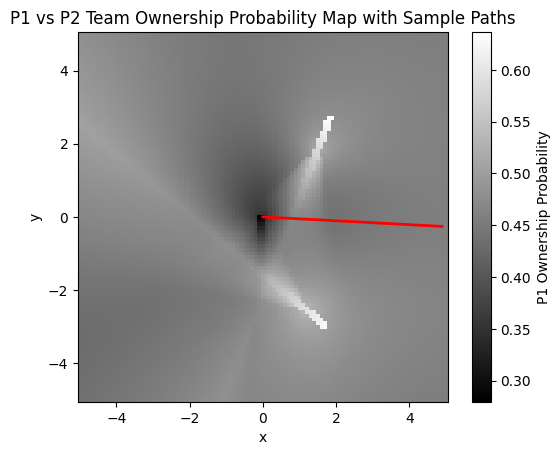

Expected y position of receiver along path: -0.08602079370273949
P_Survive: 0.05287266251101228


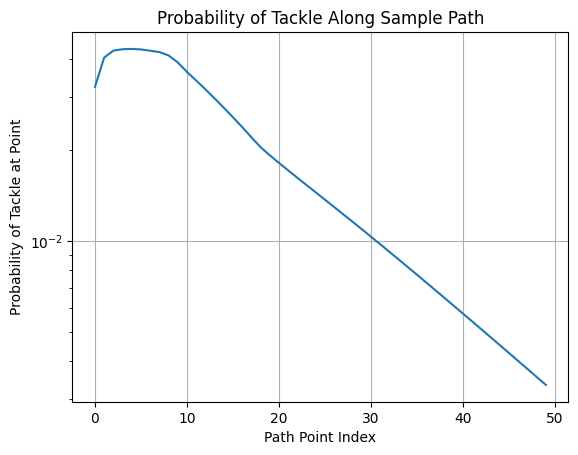

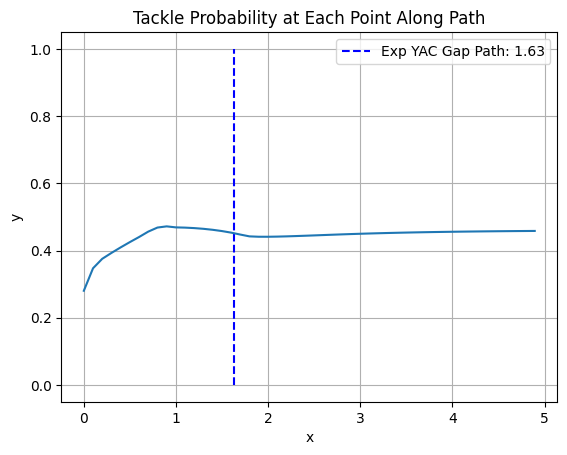

In [15]:
plt.figure()
plt.pcolormesh(XX, YY, probField, cmap='grey', shading='auto')
plt.colorbar(label='P1 Ownership Probability')
plt.xlabel('x')
plt.ylabel('y')
plt.title('P1 vs P2 Team Ownership Probability Map with Sample Paths')
plt.gca().set_aspect('equal')
#Sample paths
xs,ys=zip(*pts)
plt.plot(xs,ys,c='red',linewidth=2)
plt.show()

plt.figure()
p_survive, pkt=calc_prob_of_tackle_along_path(pts, XX,YY,probField,locald)
exp_val=expected_val_receiver(pts, p_survive, pkt, move_direc="y")
print("Expected y position of receiver along path:", exp_val)
print("P_Survive:", p_survive)
plt.plot(pkt)
plt.yscale('log')
plt.title('Probability of Tackle Along Sample Path')
plt.xlabel('Path Point Index')
plt.ylabel('Probability of Tackle at Point')
plt.grid()
plt.show()

plt.figure()
yd=[]
pkvals=[]
for pt in pts:
    rx,ry=pt
    yd.append(rx)
    pk_val=pk(rx,ry,XX,YY,probField)
    pkvals.append(pk_val)
plt.vlines(exp, ymin=0, ymax=1, color='blue', linestyle='dashed', label='Exp YAC Gap Path: {:.2f}'.format(exp))
plt.plot(yd,pkvals)
plt.title('Tackle Probability at Each Point Along Path')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

In [16]:
#Get the final positions and velocities of the play (DONE)
#Calculate the CSD/TPF in a zoomed in region (DONE)
#Assume the optimal route is a straight line along the TPF ridge (DONE)
#Calculated the expected YAC (DONE)

In [17]:
#Get the positions and velocities of the defenders for play 6517 from the input file (DONE)
#Get the position and velocity of the receiver when they caught the ball (DONE)
#Calculate how long the defenders had to react (DONE)

In [18]:
import numpy as np
from scipy.optimize import minimize_scalar

# ----------------------------
# Coordinate transform helpers
# ----------------------------

def transformToUpwardsMotion(x, y, vi, vt):
    """
    Rotate coordinates so that the initial velocity direction (angle vt)
    becomes 'straight up' (0,1) in the new frame.
    """
    ang = (np.pi / 2 - vt)  # rotation angle: original -> rotated frame
    rot = np.array([[np.cos(ang), -np.sin(ang)],
                    [np.sin(ang),  np.cos(ang)]])
    x_new, y_new = rot @ np.array([x, y])
    vi_new = vi  # speed unchanged

    # NOTE: this line enforces a left-turn-only model by mirroring targets on the right.
    # It’s kept because your original model used it, but it means the model will prefer
    # left turns even when the target is on the right.
    if x_new > 0:
        x_new = -x_new

    return x_new, y_new, vi_new, ang


# ----------------------------
# Turning segment (circular arc)
# ----------------------------

def t2time(x, y, vturn, aturnmax):
    """
    Compute time and remaining distance after a constant-speed circular turn
    at speed vturn with max turn acceleration aturnmax.

    Returns:
      t2   : time spent turning
      dnew : remaining straight-line distance after the turn
      phi1 : turn angle (radians, CCW in the rotated frame model)
    """
    r = vturn * vturn / aturnmax  # turning radius

    # Check discriminant for feasibility
    if (x**2 + 2 * r * x + y**2 < 0):
        # Inside circle -> infeasible: penalize this vturn heavily
        return 10 * vturn + 10, 10 * vturn + 100, 0.0

    phi1 = 2 * np.arctan2(-x, y + np.sqrt(x**2 + 2 * r * x + y**2))
    phi1 = phi1 % (2 * np.pi)

    t2 = r * phi1 / vturn
    newx = x - r * (1 - np.cos(phi1))
    newy = y + r * np.sin(phi1)
    dnew = np.hypot(newx, newy)

    return t2, dnew, phi1


# ----------------------------
# Straight-line motion helpers
# ----------------------------

def straight_line_kinematics(d, vi, a, vmax):
    """
    Motion along a straight line over distance d, starting at speed vi,
    with constant acceleration magnitude a and speed cap vmax (no braking).

    Returns:
      t        : time to travel distance d
      v_final  : final speed after distance d
    """
    if d <= 0:
        # No distance to cover
        return 0.0, vi

    # Speed you'd reach if you just keep accelerating with 'a' over distance d
    s = np.sqrt(vi * vi + 2 * a * d)

    if s <= vmax:
        # Never hit vmax: pure acceleration
        t = (s - vi) / a
        v_final = s
    else:
        # Hit vmax, then cruise
        t1 = (vmax - vi) / a
        d1 = (vmax * vmax - vi * vi) / (2 * a)
        d2 = d - d1
        t2 = d2 / vmax
        t = t1 + t2
        v_final = vmax

    return t, v_final


def straight_line_time(d, vi, a, vmax):
    """
    Backwards-compatible: only return time.
    """
    t, _ = straight_line_kinematics(d, vi, a, vmax)
    return t


# ----------------------------
# Core path time (original behavior: time only)
# ----------------------------

def path_time(vturn, x, y, vi, astop, ago, aturnmax, vmax):
    """
    Time to reach (x,y) in the rotated frame, given:
      vi      : initial speed
      vturn   : speed during circular turn
      astop   : deceleration rate
      ago     : acceleration rate (go)
      aturnmax: max turn acceleration
      vmax    : max speed
    """
    threshold = 0.1

    # Almost straight ahead / behind (no explicit turning circle)
    if np.abs(x) <= threshold:
        if y < 0:
            # Turn and run (via full stop then go the other way)
            t1 = vi / astop
            y1 = vi * t1 - 0.5 * astop * t1 * t1
            return vi / astop + straight_line_time(-y + y1, 0, ago, vmax)
        elif y > 0:
            # Go straight
            return straight_line_time(y, vi, ago, vmax)
        else:
            return 0.0

    # Need to reach vturn first (accelerate or decelerate)
    if vturn > vi:
        # Accelerate
        t1 = (vturn - vi) / ago
        y1 = vi * t1 + 0.5 * ago * t1 * t1
    elif vturn == vi:
        t1 = 0.0
        y1 = 0.0
    else:  # vturn < vi
        # Decelerate
        t1 = (vi - vturn) / astop
        y1 = vi * t1 - 0.5 * astop * t1 * t1

    if y == y1 and x == 0:
        # Pure accel/decel, no turn, no final segment
        return t1

    # Circular-arc turning segment at speed vturn
    t2, dnew, phi1 = t2time(x, y - y1, vturn, aturnmax)

    # Final straight segment at speed starting vturn
    time = t1 + t2 + straight_line_time(dnew, vturn, ago, vmax)
    return time


# ----------------------------
# New: path time + final speed + final heading (fixed)
# ----------------------------

def path_time_and_final_state(vturn, x, y, vi, astop, ago, aturnmax, vmax):
    """
    Same logic as path_time, but also returns:
      total_time
      v_final (speed)
      theta_rot_final (heading in ROTATED frame)

    The heading is computed from the direction of the final straight segment,
    which avoids sign errors from 'phi1' + mirroring.
    """
    threshold = 0.1
    theta_up = np.pi / 2  # initial heading in rotated frame

    # Almost straight ahead / behind (no explicit circular turn)
    if np.abs(x) <= threshold:
        if y < 0:
            # Turn and run: full stop then go straight down
            t1 = vi / astop
            y1 = vi * t1 - 0.5 * astop * t1 * t1
            t3, v_final = straight_line_kinematics(-y + y1, 0.0, ago, vmax)
            theta_rot_final = -np.pi / 2  # straight down in rotated frame
            return t1 + t3, v_final, theta_rot_final

        elif y > 0:
            # Go straight forward from vi, heading stays up
            t, v_final = straight_line_kinematics(y, vi, ago, vmax)
            theta_rot_final = theta_up
            return t, v_final, theta_rot_final

        else:
            # Already at target
            return 0.0, vi, theta_up

    # Need to reach vturn first (accelerate or decelerate), heading still up
    if vturn > vi:
        # Accelerate
        t1 = (vturn - vi) / ago
        y1 = vi * t1 + 0.5 * ago * t1 * t1
    elif vturn == vi:
        t1 = 0.0
        y1 = 0.0
    else:  # vturn < vi
        # Decelerate
        t1 = (vi - vturn) / astop
        y1 = vi * t1 - 0.5 * astop * t1 * t1

    if y == y1 and x == 0:
        # Pure accel/decel, no turn, no final segment
        # Heading remains up, speed is vturn
        return t1, vturn, theta_up

    # Circular-arc turning segment at constant speed vturn
    x_rel = x
    y_rel = y - y1
    t2, dnew, phi1 = t2time(x_rel, y_rel, vturn, aturnmax)

    # Reconstruct the post-arc relative position (same as inside t2time)
    r = vturn * vturn / aturnmax
    newx = x_rel - r * (1 - np.cos(phi1))
    newy = y_rel + r * np.sin(phi1)

    # If dnew ~ 0, the arc ends exactly at the target: use the tangent direction
    eps = 1e-8
    if dnew < eps:
        # Tangent direction after CCW arc from "up"
        theta_rot_after_turn = (theta_up + phi1) % (2 * np.pi)
        t3 = 0.0
        v_final = vturn
        return t1 + t2 + t3, v_final, theta_rot_after_turn

    # Otherwise, we have a final straight segment from (newx,newy) to target (0,0).
    # Heading is along the vector from current position towards target:
    #   vector_to_target = (-newx, -newy)
    theta_rot_after_turn = np.arctan2(-newy, -newx)

    # Final straight segment, starting at vturn along that heading
    t3, v_final = straight_line_kinematics(dnew, vturn, ago, vmax)

    return t1 + t2 + t3, v_final, theta_rot_after_turn


# ----------------------------
# Optimizers
# ----------------------------

def optimized_physics_time(x, y, vi, vt, astop, ago, aturnmax, vmax):
    """
    Returns (vturn_opt, minimal_time).
    This keeps your original behavior (time-only optimization).
    """
    x_new, y_new, vi_new, ang = transformToUpwardsMotion(x, y, vi, vt)

    # Optimize over vturn in two ranges: [0, vi] and [vi, vmax]
    res1 = minimize_scalar(
        lambda vturn: path_time(vturn, x_new, y_new, vi_new, astop, ago, aturnmax, vmax),
        bounds=(0, vi_new),
        method='bounded'
    )
    res2 = minimize_scalar(
        lambda vturn: path_time(vturn, x_new, y_new, vi_new, astop, ago, aturnmax, vmax),
        bounds=(vi_new, vmax),
        method='bounded'
    )

    res = res1 if res1.fun < res2.fun else res2
    return res.x, res.fun


def optimized_physics_time_with_final_state(x, y, vi, vt, astop, ago, aturnmax, vmax):
    """
    Returns (v_final_global, theta_global_final, minimal_time).

    - Uses time-optimal vturn (same criterion as optimized_physics_time).
    - Computes final speed and heading at the end of that path.
    - theta_global_final is in GLOBAL coordinates (same frame as vt).
    """
    # Rotate into frame where initial vel is up
    x_new, y_new, vi_new, ang = transformToUpwardsMotion(x, y, vi, vt)

    # First, find vturn that minimizes time (same objective as before)
    res1 = minimize_scalar(
        lambda vturn: path_time(vturn, x_new, y_new, vi_new, astop, ago, aturnmax, vmax),
        bounds=(0, vi_new),
        method='bounded'
    )
    res2 = minimize_scalar(
        lambda vturn: path_time(vturn, x_new, y_new, vi_new, astop, ago, aturnmax, vmax),
        bounds=(vi_new, vmax),
        method='bounded'
    )

    res = res1 if res1.fun < res2.fun else res2
    vturn_opt = res.x

    # Now compute total time, final velocity, and final HEADING in rotated frame
    total_time, v_final, theta_rot_final = path_time_and_final_state(
        vturn_opt, x_new, y_new, vi_new, astop, ago, aturnmax, vmax
    )

    # Convert heading back to GLOBAL frame:
    # rotated_angle = global_angle + ang  =>  global_angle = rotated_angle - ang
    theta_global_final = (theta_rot_final - ang) % (2 * np.pi)

    return v_final, theta_global_final, total_time


# ----------------------------
# Wrappers
# ----------------------------

def optimized_physics_time_wrapper(x, y, vi, vt, astop, ago, aturnmax, vmax):
    """
    Returns just the minimal time.
    """
    try:
        return optimized_physics_time(x, y, vi, vt, astop, ago, aturnmax, vmax)[1]
    except Exception as e:
        print(x, y, vi, vt)
        print("Error in optimization:", e)
        return np.nan


def optimized_physics_time_wrapper_get_final_velocity(x, y, vi, vt, astop, ago, aturnmax, vmax):
    """
    Returns the final speed at the end of the time-optimal path (in GLOBAL frame).
    """
    try:
        v_final, theta_final, total_time = optimized_physics_time_with_final_state(
            x, y, vi, vt, astop, ago, aturnmax, vmax
        )
        return v_final
    except Exception as e:
        print(x, y, vi, vt)
        print("Error in optimization:", e)
        return np.nan


def optimized_physics_time_wrapper_get_final_heading(x, y, vi, vt, astop, ago, aturnmax, vmax):
    """
    Returns the final heading angle (in radians, GLOBAL frame) of the
    time-optimal path.
    """
    try:
        v_final, theta_final, total_time = optimized_physics_time_with_final_state(
            x, y, vi, vt, astop, ago, aturnmax, vmax
        )
        return theta_final
    except Exception as e:
        print(x, y, vi, vt)
        print("Error in optimization:", e)
        return np.nan


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_defender_reachability(
    defender_index,
    defenders_pos,
    defenders_vs,
    defenders_vts,
    ndb,
    optimized_physics_time,
    optimized_physics_time_wrapper,
    optimized_physics_time_wrapper_get_final_velocity,
    optimized_physics_time_wrapper_get_final_heading,
    time_to_react=1.0,
    n_reachable_samples=300,
    xlim=(-6, 6),
    ylim=(-6, 6),
    resolution=0.25,
    vmax_param=10.5,
    a_go=8.0,
    a_stop=12.0,
    a_turnmax=7.0,
    v_space=2.5,
    d_space_deg=30.0,
    theta_window_deg=90.0,
    cmap_control='viridis',
    cmap_speed='plasma'
):
    """
    Package of your full workflow into one function.

    Returns
    -------
    results : dict
        {
          'fig_control': fig,
          'ax_control': ax,
          'XX': XX,
          'YY': YY,
          'TT': TT,
          'control': control,
          'reachable_df': reachable_df,
          'tested_points': tested_points
        }
    """
    # --- Defender parameters ---
    x1, y1 = defenders_pos[defender_index]
    v1 = defenders_vs[defender_index]
    vt1 = defenders_vts[defender_index] * np.pi / 180.0 % (2 * np.pi)  # radians

    print(f"Defender {defender_index}: pos=({x1:.2f},{y1:.2f}), v={v1:.3f}, heading={vt1:.3f} rad")

    # --- Control map ---
    fig, ax, XX, YY, TT, control = ndb.plot_control_map(
        lambda x, y: optimized_physics_time(
            x, y,
            vi=v1,
            vt=vt1,
            astop=a_stop,
            ago=a_go,
            aturnmax=a_turnmax,
            vmax=vmax_param
        )[1],
        xlim=xlim,
        ylim=ylim,
        resolution=resolution,
        clip_positive=False,
        cmap=cmap_control,
        normalize_method='none',
        show_contours=True
    )

    # --- Reachable mask (control < time_to_react) ---
    reachable_mask = (control < time_to_react)
    hits = np.argwhere(reachable_mask)
    m = hits.shape[0]
    print(f"Reachable grid points before subsampling: {m}")

    if m == 0:
        print("No reachable points found within time_to_react.")
        return {
            'fig_control': fig,
            'ax_control': ax,
            'XX': XX,
            'YY': YY,
            'TT': TT,
            'control': control,
            'reachable_df': pd.DataFrame(),
            'tested_points': np.empty((0, 4))
        }

    # Coordinates of ALL reachable points
    px_all = XX[hits[:, 0], hits[:, 1]]
    py_all = YY[hits[:, 0], hits[:, 1]]
    coords = np.column_stack((px_all, py_all))

    # Use farthest point sampling to get well-spaced subset
    k = min(n_reachable_samples, m)
    fps_idxs = farthest_point_sampling(coords, k)

    chosen_hits = hits[fps_idxs]
    px = px_all[fps_idxs]
    py = py_all[fps_idxs]

    # Build new mask only for chosen points (optional, if you still want a mask)
    new_mask = np.zeros_like(reachable_mask, dtype=bool)
    new_mask[chosen_hits[:, 0], chosen_hits[:, 1]] = True
    reachable_mask = new_mask

    # px, py now are your well-spaced reachable points


    # Plot selected reachable points
    ax.scatter(px, py, c='red', s=30, edgecolor='k',
               zorder=5, label='selected reachable')
    ax.legend()
    plt.show()

    reachable_points = np.column_stack((px, py))

    # --- Reach times from optimized_physics_time_wrapper ---
    reach_times = np.array([
        optimized_physics_time_wrapper(
            float(x), float(y),
            vi=v1, vt=vt1,
            astop=a_stop, ago=a_go,
            aturnmax=a_turnmax, vmax=vmax_param
        )
        for x, y in reachable_points
    ])

    print("Computed times for", reach_times.size, "points")
    print("Time stats (s): min {:.3f}, median {:.3f}, mean {:.3f}, max {:.3f}".format(
        np.nanmin(reach_times),
        np.nanmedian(reach_times),
        np.nanmean(reach_times),
        np.nanmax(reach_times)
    ))

    # --- DataFrame with time_remaining ---
    time_remaining = time_to_react - reach_times
    reachable_with_times = np.column_stack((reachable_points, reach_times, time_remaining))
    reachable_df = pd.DataFrame(
        reachable_with_times,
        columns=['x', 'y', 'reach_time', 'time_remaining']
    )

    print("Added 'time_remaining' column (time_to_react - reach_time).")
    print("time_remaining stats: min {:.3f}, median {:.3f}, mean {:.3f}, max {:.3f}".format(
        np.nanmin(time_remaining),
        np.nanmedian(time_remaining),
        np.nanmean(time_remaining),
        np.nanmax(time_remaining)
    ))

    # --- Final velocities ---
    final_vs = np.array([
        optimized_physics_time_wrapper_get_final_velocity(
            float(x), float(y),
            vi=v1, vt=vt1,
            astop=a_stop, ago=a_go,
            aturnmax=a_turnmax, vmax=vmax_param
        )
        for x, y in reachable_points
    ])

    reachable_df['final_v'] = final_vs

    print("Computed final velocities for", final_vs.size, "points")
    print("Final v stats: min {:.3f}, median {:.3f}, mean {:.3f}, max {:.3f}".format(
        np.nanmin(final_vs),
        np.nanmedian(final_vs),
        np.nanmean(final_vs),
        np.nanmax(final_vs)
    ))

    # --- v_max / v_min envelopes ---
    reachable_df['v_max'] = reachable_df['final_v'] + a_go * reachable_df['time_remaining']
    reachable_df['v_min'] = reachable_df['final_v'] - a_stop * reachable_df['time_remaining']

    reachable_df['v_max'] = reachable_df['v_max'].clip(lower=0.0)
    reachable_df['v_min'] = np.minimum(
        np.maximum(reachable_df['v_min'], 0.1),
        reachable_df['v_max']
    )

    print("v_max stats: min {:.3f}, median {:.3f}, mean {:.3f}, max {:.3f}".format(
        reachable_df['v_max'].min(),
        reachable_df['v_max'].median(),
        reachable_df['v_max'].mean(),
        reachable_df['v_max'].max()
    ))
    print("v_min stats: min {:.3f}, median {:.3f}, mean {:.3f}, max {:.3f}".format(
        reachable_df['v_min'].min(),
        reachable_df['v_min'].median(),
        reachable_df['v_min'].mean(),
        reachable_df['v_min'].max()
    ))

    # --- Final headings ---
    final_headings = np.array([
        optimized_physics_time_wrapper_get_final_heading(
            float(x), float(y),
            vi=v1, vt=vt1,
            astop=a_stop, ago=a_go,
            aturnmax=a_turnmax, vmax=vmax_param
        )
        for x, y in reachable_points
    ])

    reachable_df['final_heading'] = final_headings

    print("Computed final headings for", final_headings.size, "points")
    print("Final heading (rad) stats: min {:.3f}, median {:.3f}, mean {:.3f}, max {:.3f}".format(
        np.nanmin(final_headings),
        np.nanmedian(final_headings),
        np.nanmean(final_headings),
        np.nanmax(final_headings)
    ))

    # --- Heading-change envelope (turning-limited) ---
    eps = 1e-6
    safe_v = reachable_df['final_v'].fillna(eps).replace(0, eps)
    reachable_df['heading change'] = np.clip(
        (a_turnmax / safe_v) * reachable_df['time_remaining'],
        0.0, np.pi
    )

    two_pi = 2 * np.pi
    reachable_df['d_min'] = (reachable_df['final_heading'] - reachable_df['heading change']).clip(
        lower=0.0, upper=two_pi
    )
    reachable_df['d_max'] = (reachable_df['final_heading'] + reachable_df['heading change']).clip(
        lower=0.0, upper=two_pi
    )

    # simple heading: from origin to (x,y)
    reachable_df['simple_heading'] = np.arctan2(
        reachable_df['y'], reachable_df['x']
    ) % two_pi

    # --- Plot arrows for simple_heading * final_v ---
    fig2, ax2, XX2, YY2, TT2, control2 = ndb.plot_control_map(
        lambda x, y: optimized_physics_time(
            x, y,
            vi=v1, vt=vt1,
            astop=a_stop, ago=a_go,
            aturnmax=a_turnmax, vmax=vmax_param
        )[1],
        xlim=xlim,
        ylim=ylim,
        resolution=resolution,
        clip_positive=False,
        cmap=cmap_control,
        normalize_method='none',
        show_contours=True
    )

    df = reachable_df
    mask_valid = df['final_v'].notna() & df['simple_heading'].notna()
    xs = df.loc[mask_valid, 'x'].to_numpy()
    ys = df.loc[mask_valid, 'y'].to_numpy()
    vs2 = df.loc[mask_valid, 'final_v'].to_numpy()
    ths2 = df.loc[mask_valid, 'simple_heading'].to_numpy()

    u2 = vs2 * np.cos(ths2)
    v2 = vs2 * np.sin(ths2)

    ax2.quiver(
        xs, ys, u2, v2,
        angles='xy', scale_units='xy', scale=8.0,
        color='red', width=0.004,
        headwidth=3, headlength=4, zorder=10
    )
    ax2.scatter(xs, ys, s=8, color='black', zorder=11)
    fig2.canvas.draw()
    plt.show()

    # --- Build tested_points: (x, y, v, heading) for each reachable point ---
    tested_points_list = []
    for _, row in reachable_df.iterrows():
        x = float(row['x'])
        y = float(row['y'])
        vmin = float(row.get('v_min', 0.0))
        vmax = float(row.get('v_max', vmin))
        theta_center = float(row.get('simple_heading', 0.0))  # radians
        heading_change = float(row.get('heading change', 0.0))  # radians

        if np.isnan(vmin):
            vmin = 0.0
        if np.isnan(vmax):
            vmax = vmin
        if vmax < vmin:
            vmax = vmin

        # velocity samples
        if v_space <= 0:
            vel_vals = np.array([vmin])
        else:
            vel_vals = np.arange(vmin, vmax + 1e-9, v_space)
        if vel_vals.size == 0:
            vel_vals = np.array([vmin])

        # heading samples around theta_center within ±heading_change
        hc_deg = np.degrees(heading_change)
        if hc_deg <= 0:
            deg_offsets = np.array([0.0])
        else:
            deg_offsets = np.arange(-hc_deg, hc_deg + 1e-9, d_space_deg)
        headings_local = ((np.deg2rad(deg_offsets) + theta_center) % (2 * np.pi))

        # Cartesian product
        for v_val in vel_vals:
            for h_val in headings_local:
                tested_points_list.append((x, y, float(v_val), float(h_val)))

    tested_points = np.array(tested_points_list, dtype=float)
    print(f"Generated tested_points shape: {tested_points.shape} (rows = x,y,v,heading)")

    # --- Decimation by global window around initial defender heading vt1 ---
    if tested_points.size > 0:
        theta_window = np.deg2rad(theta_window_deg)
        pts = np.asarray(tested_points, dtype=float)
        headings_all = pts[:, 3]

        # angle difference from defender's original heading vt1
        ang_diff = np.abs(((headings_all - vt1 + np.pi) % (2 * np.pi)) - np.pi)
        mask_window = ang_diff <= theta_window
        tested_points = pts[mask_window]
        print(f"Kept {tested_points.shape[0]} / {pts.shape[0]} tested_points within ±{theta_window_deg:.1f}° of vt1.")
    else:
        print("No tested_points to filter.")

    # --- Plot tested_points on top of a fresh control map ---
    fig3, ax3, XX3, YY3, TT3, control3 = ndb.plot_control_map(
        lambda x, y: optimized_physics_time(
            x, y,
            vi=v1, vt=vt1,
            astop=a_stop, ago=a_go,
            aturnmax=a_turnmax, vmax=vmax_param
        )[1],
        xlim=xlim,
        ylim=ylim,
        resolution=resolution,
        clip_positive=False,
        cmap=cmap_control,
        normalize_method='none',
        show_contours=True
    )

    pts = np.asarray(tested_points, dtype=float)
    if pts.size == 0:
        print("No tested_points to plot.")
    else:
        xs3 = pts[:, 0]
        ys3 = pts[:, 1]
        vs3 = pts[:, 2]
        ths3 = pts[:, 3]

        u3 = vs3 * np.cos(ths3)
        v3 = vs3 * np.sin(ths3)

        sc = ax3.scatter(
            xs3, ys3, c=vs3,
            cmap=cmap_speed, s=25,
            edgecolors='k', linewidths=0.2,
            zorder=10
        )
        ax3.quiver(
            xs3, ys3, u3, v3,
            angles='xy', scale_units='xy', scale=6.0,
            color='white', width=0.004,
            headwidth=3, headlength=4,
            zorder=11, alpha=0.1
        )

        cbar = fig3.colorbar(sc, ax=ax3, label='tested speed (m/s)')
        ax3.set_aspect('equal')
        ax3.set_title('Tested Points and Headings over Control Map')

    plt.show()

    # --- Return everything useful ---
    return {
        'fig_control': fig,
        'ax_control': ax,
        'XX': XX,
        'YY': YY,
        'TT': TT,
        'control': control,
        'reachable_df': reachable_df,
        'tested_points': tested_points
    }


def farthest_point_sampling(points, k, rng=None):
    """
    points: (m, d) array of candidate points
    k: number of points to select
    returns: (k,) array of indices into `points`
    """
    points = np.asarray(points, dtype=float)
    m = points.shape[0]

    if m == 0:
        return np.array([], dtype=int)
    if m <= k:
        return np.arange(m, dtype=int)

    if rng is None:
        rng = np.random.default_rng()

    # 1) pick a random starting point
    first = rng.integers(m)
    selected = [first]

    # 2) min_dists[i] = (squared) distance from point i to the *closest* selected point
    diff = points - points[first]
    min_dists = np.einsum("ij,ij->i", diff, diff)

    for _ in range(1, k):
        # pick the point farthest from the current selected set
        idx = np.argmax(min_dists)
        selected.append(idx)

        # update min_dists with this new point
        diff = points - points[idx]
        dist2 = np.einsum("ij,ij->i", diff, diff)
        min_dists = np.minimum(min_dists, dist2)

    return np.array(selected, dtype=int)


Defender 0: pos=(95.40,8.61), v=0.900, heading=4.558 rad
Reachable grid points before subsampling: 701


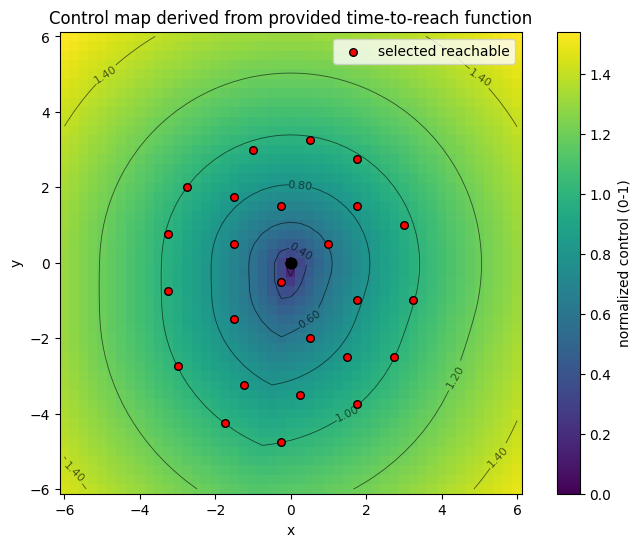

Computed times for 25 points
Time stats (s): min 0.331, median 0.966, mean 0.864, max 0.999
Added 'time_remaining' column (time_to_react - reach_time).
time_remaining stats: min 0.001, median 0.034, mean 0.136, max 0.669
Computed final velocities for 25 points
Final v stats: min 3.215, median 7.256, mean 6.776, max 8.781
v_max stats: min 7.400, median 7.512, mean 7.861, max 8.795
v_min stats: min 0.100, median 6.727, mean 5.367, max 8.759
Computed final headings for 25 points
Final heading (rad) stats: min 1.417, median 2.602, mean 2.678, max 4.246


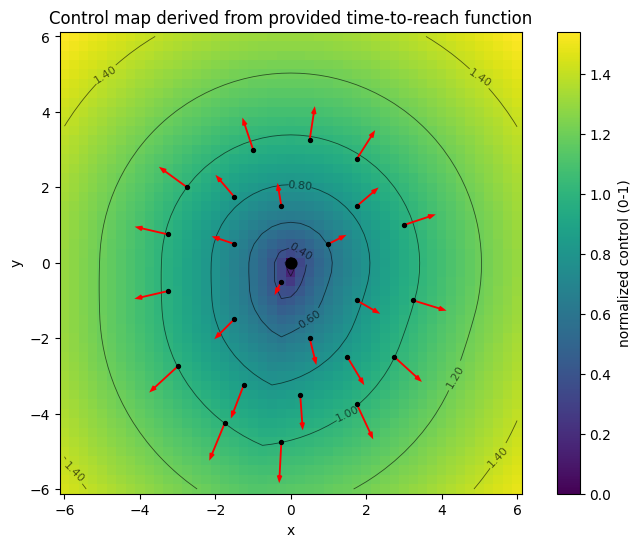

Generated tested_points shape: (233, 4) (rows = x,y,v,heading)
Kept 145 / 233 tested_points within ±90.0° of vt1.


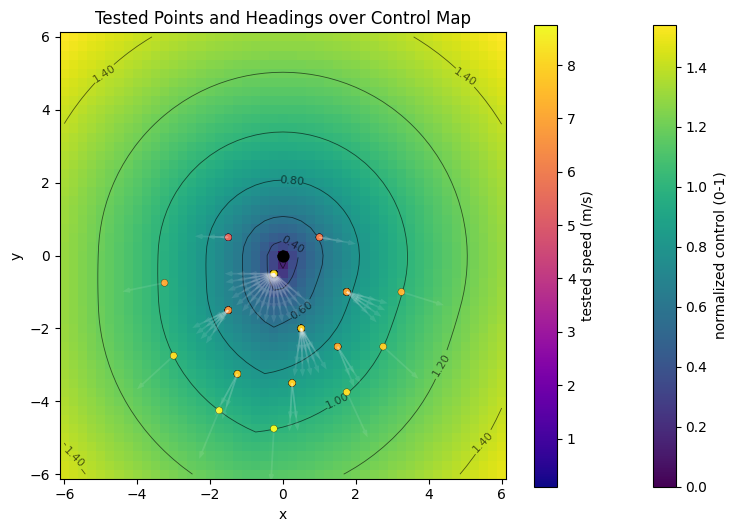

Defender 1: pos=(93.50,18.56), v=1.950, heading=2.453 rad
Reachable grid points before subsampling: 572


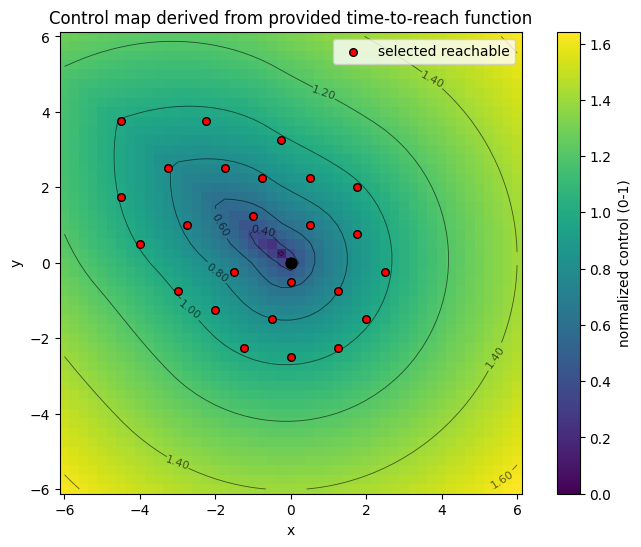

Computed times for 25 points
Time stats (s): min 0.515, median 0.920, mean 0.865, max 0.991
Added 'time_remaining' column (time_to_react - reach_time).
time_remaining stats: min 0.009, median 0.080, mean 0.135, max 0.485
Computed final velocities for 25 points
Final v stats: min 3.132, median 6.522, mean 6.643, max 9.875
v_max stats: min 6.700, median 6.882, mean 7.720, max 9.950
v_min stats: min 0.100, median 6.055, mean 5.135, max 9.764
Computed final headings for 25 points
Final heading (rad) stats: min 0.101, median 1.898, mean 2.767, max 6.139


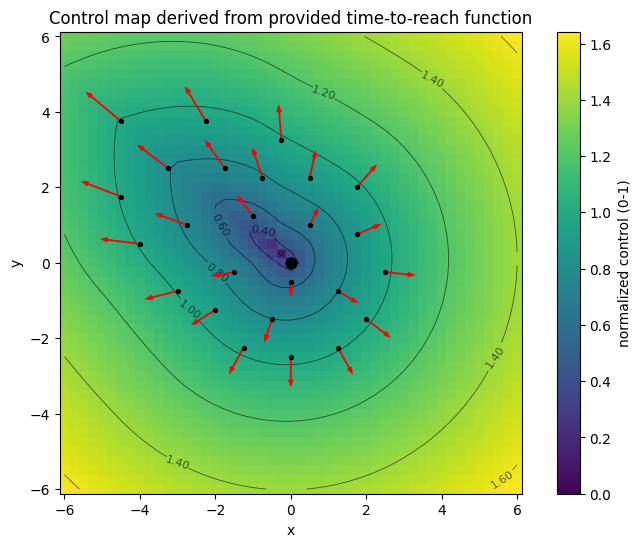

Generated tested_points shape: (158, 4) (rows = x,y,v,heading)
Kept 96 / 158 tested_points within ±90.0° of vt1.


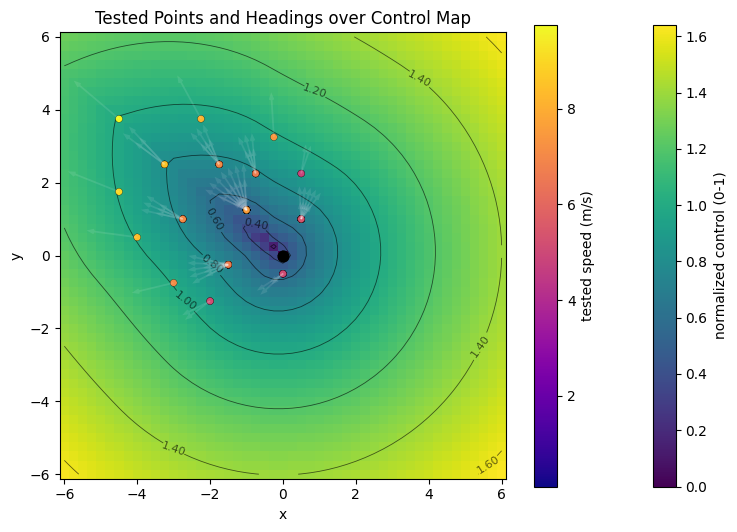

In [79]:
dat_0_out=analyze_defender_reachability(
    defender_index=0,
    defenders_pos=defenders_pos,
    defenders_vs=defenders_vs,
    defenders_vts=defenders_vts,
    ndb=ndb,
    optimized_physics_time=optimized_physics_time,
    optimized_physics_time_wrapper=optimized_physics_time_wrapper,
    optimized_physics_time_wrapper_get_final_velocity=optimized_physics_time_wrapper_get_final_velocity,
    optimized_physics_time_wrapper_get_final_heading=optimized_physics_time_wrapper_get_final_heading,
    time_to_react=1.0,
    n_reachable_samples=25,
    xlim=(-6, 6),
    ylim=(-6, 6),
    resolution=0.25,
    vmax_param=10.5,
    a_go=8.0,
    a_stop=12.0,
    a_turnmax=7.0,
    v_space=2,
    d_space_deg=10.0,
    theta_window_deg=90.0,
    cmap_control='viridis',
    cmap_speed='plasma'
)

dat_1_out=analyze_defender_reachability(
    defender_index=1,
    defenders_pos=defenders_pos,
    defenders_vs=defenders_vs,
    defenders_vts=defenders_vts,
    ndb=ndb,
    optimized_physics_time=optimized_physics_time,
    optimized_physics_time_wrapper=optimized_physics_time_wrapper,
    optimized_physics_time_wrapper_get_final_velocity=optimized_physics_time_wrapper_get_final_velocity,
    optimized_physics_time_wrapper_get_final_heading=optimized_physics_time_wrapper_get_final_heading,
    time_to_react=1.0,
    n_reachable_samples=25,
    xlim=(-6, 6),
    ylim=(-6, 6),
    resolution=0.25,
    vmax_param=10.5,
    a_go=8.0,
    a_stop=12.0,
    a_turnmax=7.0,
    v_space=2.5,
    d_space_deg=10.0,
    theta_window_deg=90.0,
    cmap_control='viridis',
    cmap_speed='plasma'
)

In [80]:
import itertools
import numpy as np
import pandas as pd
from typing import Iterable, Tuple, Optional

def create_mega_database(dat_0_out: Iterable,
                         dat_1_out: Iterable,
                         rec_info: Optional[Tuple[float, float, float, float]] = None,
                         assume_def_cols_start_at: int = 0):
    """
    Combine all possible pairs of defender candidate rows from dat_0_out and dat_1_out
    into a DataFrame with columns:
      - 'receiver_final' : tuple (rx, ry, r_vmag, r_vdir)
      - 'defender_positions' : tuple of two (x,y) tuples: ((d0x,d0y),(d1x,d1y))
      - 'defender_v_mags' : tuple (d0_vmag, d1_vmag)
      - 'defender_v_dirs' : tuple (d0_vdir, d1_vdir)

    Input formats supported for dat_*_out:
      - list/iterable of tuples/lists/ndarrays where each entry contains defender fields:
            (dx, dy, d_vmag, d_vdir)
      - OR entries that include receiver info first: (rx, ry, r_vmag, r_vdir, dx, dy, d_vmag, d_vdir)
      - OR a pandas DataFrame with appropriate columns (see detection below).

    Parameters:
      dat_0_out, dat_1_out : iterables of candidate rows
      rec_info : optional explicit receiver tuple (rx,ry,rv_mag,rv_dir). If provided, it is used
                 for every output row; otherwise the function will try to extract receiver info
                 from the first entry of dat_0_out or dat_1_out (if present).
      assume_def_cols_start_at : if your rows are numpy arrays with receiver first, set to 4 (default 0).
                                 Usually you won't need to change this.

    Returns:
      pd.DataFrame with columns listed above.
    """

    def row_to_arrays(row):
        # convert pandas Series / numpy arrays / lists / tuples to 1d numpy array
        if isinstance(row, pd.Series):
            row = row.values
        arr = np.asarray(row).ravel()
        return arr

    def extract_rec_and_def(arr, fallback_rec):
        # arr: numpy array for one candidate entry
        # returns (rec_tuple, def_tuple)
        if arr.size >= 8:
            rec = tuple(arr[:4].astype(float).tolist())
            d = tuple(arr[4:8].astype(float).tolist())
        elif arr.size >= 4:
            # arr only contains defender fields
            if fallback_rec is None:
                raise ValueError("Receiver info not provided and not present in data rows. "
                                 "Pass rec_info or provide rows containing receiver fields.")
            rec = tuple(map(float, fallback_rec))
            d = tuple(arr[:4].astype(float).tolist())
        else:
            raise ValueError("Each row must contain at least 4 numeric fields for defender (dx,dy,vmag,vdir)")
        return rec, d

    # materialize inputs as lists
    dat0_list = list(dat_0_out)
    dat1_list = list(dat_1_out)

    if len(dat0_list) == 0 or len(dat1_list) == 0:
        raise ValueError("dat_0_out and dat_1_out must be non-empty")

    # Try to determine receiver info if not provided
    fallback_rec = None
    if rec_info is not None:
        fallback_rec = tuple(rec_info)
    else:
        # attempt to parse from first entries that have 8+ fields
        try:
            arr0 = row_to_arrays(dat0_list[0])
            if arr0.size >= 8:
                fallback_rec = tuple(arr0[:4].astype(float).tolist())
        except Exception:
            pass
        if fallback_rec is None:
            try:
                arr1 = row_to_arrays(dat1_list[0])
                if arr1.size >= 8:
                    fallback_rec = tuple(arr1[:4].astype(float).tolist())
            except Exception:
                pass

    # Build output rows
    out_rows = []
    for a, b in itertools.product(dat0_list, dat1_list):
        arr_a = row_to_arrays(a)
        arr_b = row_to_arrays(b)
        rec_a, def_a = extract_rec_and_def(arr_a, fallback_rec)
        rec_b, def_b = extract_rec_and_def(arr_b, fallback_rec)

        # If both a and b carry receiver info, prefer a's receiver but ensure consistency if both have rec and differ
        if rec_info is not None:
            rec = tuple(map(float, rec_info))
        else:
            # prefer rec from a (if present), otherwise b
            rec = rec_a if arr_a.size >= 8 else rec_b

        # defender positions and mags/dirs
        d0x, d0y, d0_mag, d0_dir = map(float, def_a)
        d1x, d1y, d1_mag, d1_dir = map(float, def_b)

        row = {
            'receiver_final': tuple(rec),
            'defender_positions': ((d0x, d0y), (d1x, d1y)),
            'defender_v_mags': (d0_mag, d1_mag),
            'defender_v_dirs': (d0_dir, d1_dir),
        }
        out_rows.append(row)

    df = pd.DataFrame(out_rows, columns=['receiver_final', 'defender_positions', 'defender_v_mags', 'defender_v_dirs'])
    return df

In [81]:
start_coords=prep_for_heat(13975,df_in,n=2)
print(start_coords)
rec = start_coords[0]
mega_df = create_mega_database(dat_0_out['tested_points'], dat_1_out['tested_points'], rec_info=rec)

((91.0, 14.32, 2.6172504656605233, -0.8124186125846928), ((81.6, 23.72), (95.28, 8.61), (102.5, 15.43), (93.61, 18.39), (93.88, 31.03), (87.72, 48.11), (95.2, 37.52), (93.33, 37.95), (94.14, 11.24), (91.26, 32.96), (103.4, 33.5), (95.9, 46.36)), (0.4472135955000278, 1.2000000000000455, 2.23606797749978, 2.02484567313164, 2.7313000567495305, 1.835755975068569, 3.4438350715445583, 6.400781202322134, 6.2649820430709005, 3.1622776601684017, 2.863564212655306, 1.7204650534085384), (-2.0344439357958803, 3.141592653589793, -0.17985349979248325, -0.9964914966201922, 1.1562894522101126, 1.0584068664841335, 1.120135000714251, 0.5055810548742066, 0.42794849632147697, 0.9652516631899053, 0.43240777557052223, 0.6202494859828263))


In [82]:
display(mega_df)
mega_path = os.path.join(os.path.dirname(out_path), 'mega_df.parquet')
mega_df.to_parquet(mega_path)
print(f"Saved mega_df to {mega_path} (rows={mega_df.shape[0]}, cols={mega_df.shape[1]})")

,receiver_final,defender_positions,defender_v_mags,defender_v_dirs
0,"(91.0, 14.32, 2.6172504656605233, -0.812418612...","((-1.5, 0.5), (-2.25, 3.75))","(1.498094057591338, 8.14605178130639)","(3.1080572525021224, 2.0702677607058)"
1,"(91.0, 14.32, 2.6172504656605233, -0.812418612...","((-1.5, 0.5), (-3.0, -0.75))","(1.498094057591338, 7.090581150926676)","(3.1080572525021224, 3.377050465820977)"
2,"(91.0, 14.32, 2.6172504656605233, -0.812418612...","((-1.5, 0.5), (-4.5, 1.75))","(1.498094057591338, 9.044088909869425)","(3.1080572525021224, 2.7636128123526134)"
3,"(91.0, 14.32, 2.6172504656605233, -0.812418612...","((-1.5, 0.5), (-1.0, 1.25))","(1.498094057591338, 0.1)","(3.1080572525021224, 1.6389251469159989)"
4,"(91.0, 14.32, 2.6172504656605233, -0.812418612...","((-1.5, 0.5), (-1.0, 1.25))","(1.498094057591338, 0.1)","(3.1080572525021224, 1.813458072115432)"
...,...,...,...,...
13915,"(91.0, 14.32, 2.6172504656605233, -0.812418612...","((1.5, -2.5), (-0.75, 2.25))","(7.175655046269119, 4.175203442924385)","(5.276808235970178, 1.8399901041050137)"
13916,"(91.0, 14.32, 2.6172504656605233, -0.812418612...","((1.5, -2.5), (-0.75, 2.25))","(7.175655046269119, 4.175203442924385)","(5.276808235970178, 2.014523029304447)"
13917,"(91.0, 14.32, 2.6172504656605233, -0.812418612...","((1.5, -2.5), (-0.75, 2.25))","(7.175655046269119, 6.675203442924385)","(5.276808235970178, 1.6654571789055808)"
13918,"(91.0, 14.32, 2.6172504656605233, -0.812418612...","((1.5, -2.5), (-0.75, 2.25))","(7.175655046269119, 6.675203442924385)","(5.276808235970178, 1.8399901041050137)"


Saved mega_df to /Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/mega_df.parquet (rows=13920, cols=4)


In [ ]:
#For both defenders, calculate using the physics_time method what areas they could reach in the given time and how long to reach those areas (DONE)
#Restrict the domain to points in the general direction of the receiver (Didn't Do)
#Sample n points in that grid (DONE)
#You can transform those point times into how long after they reach that point they have to change their velocity (DONE)
#Use a_stop/a_go to calculate the possible minimum/maximum velocity (DONE)
#Choose the minimum, a couple intermediates, and then the maximum velocity points (DONE)
#Assume that the straight line direction between their start and their end position is their default orientation (DONE)
#The higher their velocity, the less their orientation can change. Use some reasonable sine function, be generous (DONE)
#From the velocties, get the possible directions. It should be a realitively small range, so we can sample a couple points. (DONE)
#For each defender we should get n * 6 (velocity points) *6 (orientation) points which should hopefully run realitively quickly (WAY MORE)

#For each of the points, we now want to calculate the CSD/TPF which we can straightforwardly do
#Assume that ball carrier's ideal path is a straight line along the TPF ridge
#Calculate the p_catch, tackle probability of catch, and expected YAC

#Do the same for all the points
#Find the orientation that minimized expected YAC


In [ ]:
#Create a long-exposure plot of the path that the defenders actually took and the CSD
#On the long-exposure plot, show the optimal paths and the resulting CSD